In [1]:
using Random, Distributions
using PyPlot#Plots#, PlotlyJS
using CSV
using DataFrames

# Define parameters of Jordi's paper

In [2]:
#List cell parameters
cellJordi = DataFrame()
cellJordi."x" = AbstractFloat[]
cellJordi."xNeigh" = AbstractFloat[]
cellJordi."x1" = AbstractFloat[]
cellJordi."x2" = AbstractFloat[]
cellJordi."x3" = AbstractFloat[]
cellJordi."v1" = AbstractFloat[]
cellJordi."v2" = AbstractFloat[]
cellJordi."v3" = AbstractFloat[]
cellJordi."f1" = AbstractFloat[]
cellJordi."f2" = AbstractFloat[]
cellJordi."f3" = AbstractFloat[]
cellJordi."r" = AbstractFloat[]
cellJordi."m" = AbstractFloat[]
#It is not necewssary to include the num of neighbours if your do not want to, that is defined during the neighbours declaration

#List of community parameters
communityJordi = DataFrame()
communityJordi."mInitial" = [10^-6.]
communityJordi."rInitial" = [5.]
communityJordi."b" = [10^-6.]
communityJordi."F0" = [10^-4.]
communityJordi."μ" = [2.]
#Not necessary to be defined the number of cells that you have

1-element Array{Float64,1}:
 2.0

# Dynamics

In [3]:
mutable struct Dynamics
    variables::Array{String}
    f
    integrator
    activationCondition
    deactivationCondition
end

In [4]:
#Integrators
function rungeKutta4(variables,f::Function,t,dt,cell,glob)
    k0 = [cell[i] for i in variables]
    k1 = f(k0,t,cell,glob)
    k2 = f(k0+0.5*k1*dt,t+0.5*dt,cell,glob)
    k3 = f(k0+0.5*k2*dt,t+0.5*dt,cell,glob)
    k4 = f(k0+k3*dt,t+dt,cell,glob)
    return k0+(k1+2*k2+2*k3+k4)*dt/6
end

function heuns(variables,f::Function,t,dt,cell,glob)
    k0 = [cell[i] for i in variables]
    k1 = f(k0,t,cell,glob)
    k2 = f(k0+k1*dt,t+dt,cell,glob)
    return k0+(k1+k2)*dt/2
end

heuns (generic function with 1 method)

In [5]:
#Mechanics of jordi's paper
variablesMechanics = ["v1","v2","v3","x1","x2","x3"]
function mechanics(vars,t,cell,glob)
    v1,v2,v3,x1,x2,x3 = vars
    dv1dt = (-glob["b"]*v1+cell["f1"])/cell["m"]
    dv2dt = (-glob["b"]*v2+cell["f2"])/cell["m"]
    dv3dt = (-glob["b"]*v3+cell["f3"])/cell["m"]
    dx1dt = v1
    dx2dt = v2
    dx3dt = v3
    return [dv1dt,dv2dt,dv3dt,dx1dt,dx2dt,dx3dt]
end

mechanicsJordi = Dynamics(variablesMechanics,mechanics,heuns,Nothing,Nothing)

Dynamics(["v1", "v2", "v3", "x1", "x2", "x3"], mechanics, heuns, Nothing, Nothing)

In [6]:
#Biochemistry of jordi's paper
#Dynamics
variablesBiochemistry = ["x"]
function biochemistry(vars,t,cell,glob)
    x, = vars
    dxdt = glob["α"]*(1+x^glob["n"])^glob["m"]/((1+x^glob["n"])^glob["m"]+(cell["xNeigh"]^glob["n"]/glob["K"])^(2*glob["m"]))-x
    return [dxdt]
end

biochemicsJordi = Dynamics(variablesBiochemistry,biochemistry,heuns, Nothing, Nothing)

Dynamics(["x"], biochemistry, heuns, Nothing, Nothing)

# Cell-Cell interactions

In [7]:
mutable struct CellCell
    variables::Array{String}
    context::Array{String}
    f
    fContext
    neighboursCondition
    activationCondition
    deactivationCondition
end

In [8]:
parametersForce = ["f1","f2","f3"]
function force(cell1,cell2,pos1,pos2,t,glob,neighboursN,neighboursList)
    if pos1 != pos2
        rij = cell1["r"]+cell2["r"]
        d = sqrt((cell1["x1"]-cell2["x1"])^2+(cell1["x2"]-cell2["x2"])^2+(cell1["x3"]-cell2["x3"])^2)
        return glob["F0"]*(rij/d-1)*(glob["μ"]*rij/d-1)/d.*[cell1["x1"]-cell2["x1"],cell1["x2"]-cell2["x2"],cell1["x3"]-cell2["x3"]]
    else
        return 0.
    end
end
function neighboursForce(cell1,cell2,pos1,pos2,t,glob)
    rij = cell1["r"]+cell2["r"]
    d = sqrt((cell1["x1"]-cell2["x1"])^2+(cell1["x2"]-cell2["x2"])^2+(cell1["x3"]-cell2["x3"])^2)
    if d < glob["μ"]*rij
        return true
    else
        return false
    end
end

cellCellMechanicsJordi = CellCell(parametersForce,[],force,Nothing,neighboursForce,Nothing,Nothing)

CellCell(["f1", "f2", "f3"], String[], force, Nothing, neighboursForce, Nothing, Nothing)

In [9]:
parametersBiochem = ["xNeigh"]
function diffussion(cell1,cell2,pos1,pos2,t,glob,neighboursN,neighboursList)
    return cell2["x"]/neighboursN
end
function neighboursDiffusion(cell1,cell2,pos1,pos2,t,glob)
    rij = cell1["r"]+cell2["r"]
    d = sqrt((cell1["x1"]-cell2["x1"])^2+(cell1["x2"]-cell2["x2"])^2+(cell1["x3"]-cell2["x3"])^2)
    if d < glob["fRange"]*rij
        return true
    else
        return false
    end
end

cellCellBiochemJordi = CellCell(parametersBiochem,[],diffussion,Nothing,neighboursDiffusion,Nothing,Nothing)

CellCell(["xNeigh"], String[], diffussion, Nothing, neighboursDiffusion, Nothing, Nothing)

# Division

In [10]:
mutable struct Division
    variables::Array{String}
    f
    divisionCondition
    activationCondition
    deactivationCondition
end

# Create community

In [11]:
mutable struct Community
    cells::Array{DataFrameRow}
    glob::DataFrameRow
    t_::Real
    n_::Integer
    lastId_::Integer
    
    function Community(cell::DataFrame,commParameters::DataFrame,t=0.,n=1,id=1)
        if nrow(cell) == 0
            cell2 = deepcopy(cell)
            push!(cell2,reshape([0 for i in 1:length(names(cell2))],(1,length(names(cell2)))))
            cell2.id_ = Int[1]
        else
            cell2 = deepcopy(cell)
            cell2.id_ = Int[1]
        end
        if nrow(commParameters) == 0
            commParameters2 = deepcopy(commParameters)
            push!(commParameters2,reshape([0 for i in 1:length(names(commParameters2))],(1,length(names(commParameters2)))))
        else
            commParameters2 = deepcopy(commParameters)
        end

        new([deepcopy(cell2[1,:]) for i in 1:n],commParameters2[1,:],t,n,id)
    end
    
end

In [12]:
function assign!(com::Community,par::String,val::Real)
    if par in keys(com.commParameters)
        com.commParameters[par] = val
    elseif par in keys(com.cells[1])
        for i in com.cells
            com.cells[par] = val
        end
    else
        println(par, " not a parameter of the community.")
    end
    
    return
end

function assign!(com::Community,par::String,val::Array{Real})
    if length(val) != com.n
        print("val array has more values than cells are in the community.")
    elseif par in keys(com.cells[1])
        for i in com.cells
            com.cells[par] = val()
        end
    else
        println(par, " is not a parameter of the cells.")
    end
        
    return
end

assign! (generic function with 2 methods)

In [13]:
#Create a Jordi's community

commJordi = Community(cellJordi,communityJordi);

# Make model

In [14]:
mutable struct AgentBasedModel
    community::Community
    dynamics::Array{Dynamics}
    cellCell::Array{CellCell}
    division#::Division
    
    function AgentBasedModel(;cell::DataFrame,commParameters::DataFrame,t=0,n=1,dynamics::Array{Dynamics}=[],cellCell::Array{CellCell}=[],division=Nothing)
        new(Community(cell,commParameters,t,n),dynamics,cellCell,division)
    end
end

In [15]:
abm = AgentBasedModel(cell=cellJordi,commParameters=communityJordi,dynamics=[mechanicsJordi],cellCell=[cellCellMechanicsJordi]);

# Saving model

In [16]:
function saveGlobal(community)
    #Extract names
    nam = keys(community.glob)
    #Append 
    data = DataFrame()
    data.t_ = [Float64(community.t_)]
    data.n_ = [community.n_]
    data.lastId_ = [community.lastId_]
    for i in nam
        data[:,i] .= [community.glob[i]]
    end

    return data
end

function saveCells(community)
    #Extract names
    nam = keys(community.cells[1])
    #Append 
    data = DataFrame()
    data.t_ = [Float64(community.t_)]
    data.n_ = [community.n_]
    data.lastId_ = [community.lastId_]
    for i in nam
        data[:,i] .= [[community.cells[c][i] for c in 1:community.n_]]
    end

    return data
end

function saveGlobal!(dataframe, community)
    #Extract names
    nam = keys(community.glob)
    #Append 
    data = DataFrame()
    data.t_ = [community.t_]
    data.n_ = [community.n_]
    data.lastId_ = [community.lastId_]
    for i in nam
        data[:,i] .= [community.glob[i]]
    end

    append!(dataframe,data)
    
    return Nothing
end

function saveCells!(dataframe, community)
    #Extract names
    nam = keys(community.cells[1])
    #Append 
    data = DataFrame()
    data.t_ = [community.t_]
    data.n_ = [community.n_]
    data.lastId_ = [community.lastId_]
    for i in nam
        data[:,i] .= [[community.cells[c][i] for c in 1:community.n_]]
    end

    append!(dataframe,data)
    
    return Nothing
end

function saveGlobalFile(fileName, community; header=false)
    #Extract names
    nam = keys(community.glob)
    #Append 
    if header
        data = DataFrame()
        data.t_ = [community.t_]
        data.n_ = [community.n_]
        data.lastId_ = [community.lastId_]
        for i in nam
            data[:,i] .= [community.glob[i]]
        end
        #Save file
        CSV.write(string(fileName,"_global"), data)
    else
        data = DataFrame()
        data.t_ = [community.t_]
        data.n_ = [community.n_]
        data.lastId_ = [community.lastId_]
        for i in nam
            data[:,i] = [community.glob[i]]
        end
        #Save file
        CSV.write(string(fileName,"_global"), data, append=true)
    end

    return Nothing
end

function saveCellsFile(fileName, community; header=false)
    #Extract names
    nam = keys(community.cells[1])
    #Append 
    if header
        data = DataFrame()
        data.t_ = [community.t_]
        data.n_ = [community.n_]
        data.lastId_ = [community.lastId_]
        for i in nam
            data[:,i] .= [[community.cells[c][i] for c in 1:community.n_]]
        end
        #Save file
        CSV.write(string(fileName,"_cells"), data)
    else
        data = DataFrame()
        data.t_ = [community.t_]
        data.n_ = [community.n_]
        data.lastId_ = [community.lastId_]
        for i in nam
            data[:,i] = [[community.cells[c][i] for c in 1:community.n_]]
        end
        #Save file
        CSV.write(string(fileName,"_cells"), data, append=true)
    end

    return Nothing
end

saveCellsFile (generic function with 1 method)

# Evolve model

In [17]:
function evolve(abm::AgentBasedModel,dt,tEnd
        ;maxNumCells=1000, 
        maxNumNeighbours=Nothing,stepsRecomputeNeighbours=dt,
        saveInRAM=true,saveInFile=false,stepsSave=dt,nameSavingFile="aux")
    #Allocate memory
    append!(abm.community.cells,fill(deepcopy(abm.community.cells[1]),maxNumCells-abm.community.n_))
    ##Make sure that they are copies
    for i in abm.community.n_+1:maxNumCells
        abm.community.cells[i] = deepcopy(abm.community.cells[1])
    end
    #Create auxilitary arrays
    auxDyn = [zeros(length(dyn.variables)) for dyn in abm.dynamics]
    if maxNumNeighbours == Nothing
        auxNn = [zeros(Int,maxNumCells) for dyn in abm.cellCell]
        auxNnList = [zeros(Int,maxNumCells,maxNumCells) for dyn in abm.cellCell]
    else
        auxNn = [zeros(Int,maxNumCells) for dyn in abm.cellCell]
        auxNnList = [zeros(Int,maxNumCells,maxNumNeighbours) for dyn in abm.cellCell]        
    end
    auxContext = [zeros(maxNumCells,length(dyn.context)) for dyn in abm.cellCell]
    auxCellcell = [zeros(maxNumCells,length(dyn.variables)) for dyn in abm.cellCell]
    auxDividing = 0
    auxDivisionList = zeros(Int,length(maxNumCells))
    #Create parenthood DataFrame
    parenthood = DataFrame(parent = Int[], daughter1 = Int[], daughter2 = Int[])
    
    #Save initial parameters and create files
    if saveInFile
        saveGlobalFile(nameSavingFile,abm.community,header=true)
        saveCellsFile(nameSavingFile,abm.community,header=true)
    end
    if saveInRAM
        dataGlobal = saveGlobal(abm.community)
        dataCells = saveCells(abm.community)
    end
    #Initialise time of saving
    timeSaving = abm.community.t_+stepsSave
       
    while abm.community.t_ < tEnd
        
        #Nearest neighbors
        for i in 1:length(abm.cellCell)
            if abm.cellCell[i].neighboursCondition != Nothing
                for j in 1:abm.community.n_
                    #Reset neighbours
                    auxNn[i][j] = 0
                    for k in 1:abm.community.n_
                        if abm.cellCell[i].neighboursCondition(abm.community.cells[j],abm.community.cells[k],j,k,abm.community.t_,abm.community.glob)
                            auxNn[i][j] += 1
                            auxNnList[i][j,auxNn[i][j]] = k
                        end
                    end
                end
            end
        end
        
        #Contextual parameters
        for i in 1:length(abm.cellCell)
            if abm.cellCell[i].fContext != Nothing
                #Compute new parameters
                for j in 1:abm.community.n_
                    #Reset context
                    auxContext[i][j,:] .= 0
                    for k in auxNnList[i][j,1:auxNn[i][j]]
                        auxContext[i][j,:] .+= abm.cellCell.fContext(abm.community.cells[j],abm.community.cells[k],
                                                                    j,k,
                                                                    abm.community.t_,abm.community.glob,
                                                                    auxNn[i][j],auxNnList[i][j,:])
                    end
                end
                #Update cells
                for j in 1:abm.community.n_
                    for (pos,var) in enumerate(abm.cellCell[i].context)
                        abm.community.cells[j][var] = auxContext[i][j,pos]
                    end
                end
            end
        end
        
        #Cell-cell interactions
        for i in 1:length(abm.cellCell)
            #Compute new parameters
            for j in 1:abm.community.n_
                #Reset context
                auxCellcell[i][j,:] .= 0
                for k in auxNnList[i][j,1:auxNn[i][j]]
                    auxCellcell[i][j,:] .+= abm.cellCell[i].f(abm.community.cells[j],abm.community.cells[k],
                                                            j,k,
                                                            abm.community.t_,abm.community.glob,
                                                            auxNn[i][j],auxNnList[i][j,:])
                end
            end
            #Update cells
            for j in 1:abm.community.n_
                for (pos,var) in enumerate(abm.cellCell[i].variables)
                    abm.community.cells[j][var] = auxCellcell[i][j,pos]
                end
            end
        end
        
        #Dynamics
        for i in 1:length(abm.dynamics)
            for j in 1:abm.community.n_
                auxDyn[i] .= abm.dynamics[i].integrator(abm.dynamics[i].variables,abm.dynamics[i].f,abm.community.t_,dt,abm.community.cells[j],abm.community.glob)
                for (pos,var) in enumerate(abm.dynamics[i].variables)
                    abm.community.cells[j][var] = auxDyn[i][pos]
                end
            end
        end
        
        #Division events
        ##List dividing cells
        if abm.division != Nothing
            auxDividing = 0
            for i in 1:abm.community.n_
                if abm.division.divisionCondition(abm.community.cells[i],abm.community.t_,abm.community.glob)
                    auxDividing += 1
                    auxDivisionList[auxDividing] = i
                end
            end
            ##Make divisions
            if auxDividing > 0
                for i in auxDivisionList[1:auxDividing]
                    abm.division.f(abm.community.cells[i]
                                ,abm.community.cells[abm.community.n_+1],abm.community.cells[abm.community.n_+2]
                                ,abm.community.t_,abm.community.glob)
                    #Save split process
                    push!(parenthood,[abm.community.cells[i].id_,abm.community.lastId_+1,abm.community.lastId_+2])
                    #Update cell ids
                    abm.community.cells[i] = deepcopy(abm.community.cells[abm.community.n_+2])
                    abm.community.cells[i].id_ = abm.community.lastId_+1
                    abm.community.cells[abm.community.n_+1].id_ = abm.community.lastId_+2
                    abm.community.lastId_ += 2
                    #Increase community number
                    abm.community.n_ += 1
                end
            end
        end
                            
        #Save events
        if saveInRAM || saveInFile
            if timeSaving < abm.community.t_
                if saveInFile
                    saveGlobalFile(nameSavingFile,abm.community)
                    saveCellsFile(nameSavingFile,abm.community)
                end
                if saveInFile
                    saveGlobal!(dataGlobal,abm.community)
                    saveCells!(dataCells,abm.community)
                end
                timeSaving += stepsSave
            end
        end
        #Update time
        abm.community.t_ += dt
    end
    
    return dataGlobal, dataCells, parenthood
end

evolve (generic function with 1 method)

In [18]:
abm = AgentBasedModel(cell=cellJordi,commParameters=communityJordi,n=2,dynamics=[mechanicsJordi],cellCell=[cellCellMechanicsJordi])

abm.community.glob["b"] = 10^-6
abm.community.glob["F0"] = 10^-4

direction = [1,1,1]
direction /= sqrt(sum(direction.^2))

abm.community.cells[1]["m"] = 10^-6.
abm.community.cells[1]["r"] = 5/2^(1/3)
abm.community.cells[1]["x1"] = 0
abm.community.cells[1]["v1"] = 0
abm.community.cells[1]["v2"] = 0
abm.community.cells[1]["v3"] = 0
abm.community.cells[1]["id_"] = 1
abm.community.cells[1]["x"] = 1

abm.community.cells[2]["m"] = 10^-6.
abm.community.cells[2]["r"] = 5/2^(1/3)
abm.community.cells[2]["x1"] = 5*direction[1]
abm.community.cells[2]["x2"] = 5*direction[2]
abm.community.cells[2]["x3"] = 5*direction[3]
abm.community.cells[2]["v1"] = 0
abm.community.cells[2]["v2"] = 0
abm.community.cells[2]["v3"] = 0
abm.community.cells[2]["id_"] = 2
abm.community.cells[2]["id_"] = 0

dataGlobal, dataCells, parenthood = evolve(abm,0.005,20,stepsSave=0.01,saveInFile=true,nameSavingFile="Proba");

In [22]:
abm = AgentBasedModel(cell=cellJordi,commParameters=communityJordi,n=2,dynamics=[mechanicsJordi],cellCell=[cellCellMechanicsJordi])
direction = [1,0,0]
direction /= sqrt(sum(direction.^2))

abm.community.cells[1]["m"] = 10^-6.
abm.community.cells[1]["r"] = 5/2^(1/3)
abm.community.cells[1]["x1"] = 0
abm.community.cells[1]["v1"] = 0
abm.community.cells[1]["id_"] = 1
abm.community.cells[1]["x"] = 1

abm.community.cells[2]["m"] = 10^-6.
abm.community.cells[2]["r"] = 5/2^(1/3)
abm.community.cells[2]["x1"] = 5*direction[1]
abm.community.cells[2]["x2"] = 5*direction[2]
abm.community.cells[2]["x3"] = 5*direction[3]
abm.community.cells[2]["v1"] = 0
abm.community.cells[2]["id_"] = 2
abm.community.cells[2]["x"] = 0

figure(figsize=[10,5])
suptitle(L"$b=10^{-6}$ $F_0=10^{-4}$")
subplot(string(221))
x = 5:0.01:20
a = []
for i in x
    abm.community.cells[2]["x1"] = i
    push!(a,abm.cellCell[1].f(abm.community.cells[1], abm.community.cells[2], 1, 2, 0, abm.community.glob, Nothing, Nothing))
end
plot(x,[i[1] for i in a])

cell1=extractCell(dataCells,1)
cell2=extractCell(dataCells,2)

d = sqrt.((cell2[2:end,"x1"]-cell1[2:end,"x1"]).^2+(cell2[2:end,"x2"]-cell1[2:end,"x2"]).^2+(cell2[2:end,"x3"]-cell1[2:end,"x3"]).^2)
f = sqrt.(cell1[2:end,"f1"].^2+cell1[2:end,"f2"].^2+cell1[2:end,"f3"].^2)
plot(d,f)

vlines(5,minimum(a),maximum(a))
scatter(d[end],0)
grid()

xlabel("Distance")
ylabel("Attachment force")
#legend(["Potential", "Trajectory of jumps", "Initial distance between cells", "Final point"])
show()

subplot(string(222))
plot(cell1[:,"t_"],cell1[:,"x2"])
plot(cell2[:,"t_"],cell2[:,"x2"])
xlabel("time (a.u.)")
ylabel("position x1")
legend(["Cell1","Cell2"])

LoadError: BoundsError: attempt to access 2000×17 DataFrame
  at index [2001, "id_"]

# Manipulations

In [21]:
function extractCell(dataframe,id)
    #Find window where id appeared
    start = 1
    stop = last
    while !(id in dataframe[start,"id_"])
        start += 1
    end
    stop = start
    while (id in dataframe[stop,"id_"]) && stop < nrow(dataframe)-1
        stop += 1
    end
    stop = stop-1

    #Find position of the cell in array
    pos = findfirst(dataframe[start,"id_"].==id)
    #Extract cell
    data = DataFrame()
    data.t_ = dataframe[start:stop,"t_"]
    data.n_ = dataframe[start:stop,"n_"]
    data.lastId_ = dataframe[start:stop,"lastId_"]
    for i in [var for var in names(dataCells) if !(var in ["t_","n_","lastId_"])]
        data[:,i] = [com[pos] for com in dataframe[start:stop,i]]
    end
    
    return data
end

extractCell (generic function with 1 method)

# Visualization

In [642]:
for i in [1,2,3]
    cell=extractCell(dataCells,i)
    plot(cell[:,"t_"],cell[:,"x2"])
    plot(cell[:,"t_"],cell[:,"f2"]./cell[:,"m"]*10)
    legend([1,1,2,2,3,3])
end
show()

LoadError: BoundsError: attempt to access 2000×17 DataFrame
  at index [2001, "id_"]

## 3D plot

In [643]:
function visualize(data,t,posVars,radiVar)
    n = 100
    u = range(0,stop=2*π,length=n);
    v = range(0,stop=π,length=n);

    x = cos.(u) * sin.(v)';
    y = sin.(u) * sin.(v)';
    z = ones(n) * cos.(v)';
    
    idCells = data[t,"id_"]
    for i in idCells
        pos = findfirst(idCells.==i)
        surf(x.*data[t,radiVar][pos].+data[t,posVars[1]][pos],
             y.*data[t,radiVar][pos].+data[t,posVars[2]][pos],
             z.*data[t,radiVar][pos].+data[t,posVars[3]][pos],
             rstride=4, cstride=4)    
    end
    
    return
end

visualize (generic function with 1 method)

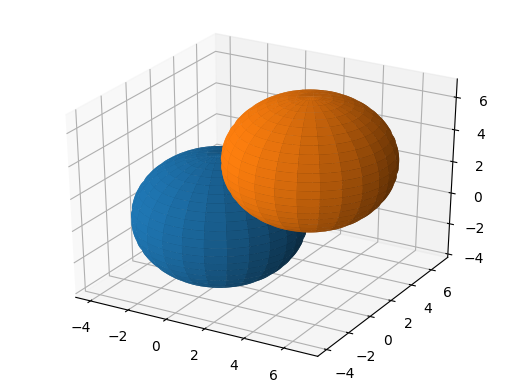

In [644]:
visualize(dataCells,3,["x1","x2","x3"],"r")
#axis([-1,1,-1,1])
show()